<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/Image_Classification_with_Vision_Transformer_Implementing_the_Vision_Transformer_(ViT)_model_for_image_classification_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -U tensorflow-addons


     |████████████████████████████████| 706kB 9.2MB/s 


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

In [ ]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169009152/169001437 [==============================] - 4s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

In [ ]:
data_augmentation = keras.Sequential([
                                      layers.experimental.preprocessing.Normalization(),
                                      layers.experimental.preprocessing.Resizing(image_size, image_size),
                                      layers.experimental.preprocessing.RandomFlip('horizontal'),
                                      layers.experimental.preprocessing.RandomRotation(factor = 0.02),
                                      layers.experimental.preprocessing.RandomZoom(height_factor=0.2, width_factor=0.2)
], name = 'data_augmentation')

# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [ ]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation=tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x 

In [ ]:
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super(Patches, self).__init__()
    self.patch_size = patch_size 

  def call(self, images):
    batch_size = tf.shape(images)[0]
    patches = tf.image.extract_patches(images=images, sizes=[1, self.patch_size, self.patch_size, 1], strides=[1, self.patch_size, self.patch_size, 1], rates=[1,1,1,1], padding='VALID')
    patch_dims = patches.shape[-1]
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    return patches

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108


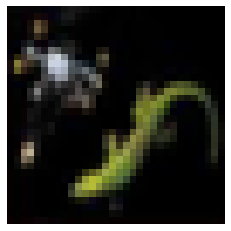

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize= (4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(tf.convert_to_tensor([image]), size= (image_size, image_size))
patches = Patches(patch_size)(resized_image)

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

In [ ]:
patches[0]

<tf.Tensor: shape=(144, 108), dtype=float32, numpy=
array([[8.0000000e+00, 6.0000000e+00, 4.0000000e+00, ..., 5.9351850e+00,
        4.3209895e-01, 5.0987654e+00],
       [8.4444447e+00, 3.3888888e+00, 7.6111112e+00, ..., 6.9197525e+01,
        5.1595676e+01, 3.6672836e+01],
       [3.0000000e+00, 3.0555558e+00, 1.1111112e+01, ..., 6.7438264e+00,
        1.2037036e+01, 1.2277778e+01],
       ...,
       [0.0000000e+00, 5.5555344e-02, 0.0000000e+00, ..., 6.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 5.5555344e-02, 0.0000000e+00, ..., 6.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 5.5555344e-02, 0.0000000e+00, ..., 7.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)>

In [ ]:
patches[0][0]

<tf.Tensor: shape=(108,), dtype=float32, numpy=
array([8.        , 6.        , 4.        , 7.1666665 , 6.1666665 ,
       4.3333335 , 4.9444447 , 6.611111  , 5.2222223 , 3.388889  ,
       6.7777777 , 6.111111  , 6.5       , 5.        , 7.        ,
       9.611111  , 3.2222223 , 7.888889  , 7.5       , 5.5       ,
       3.5       , 6.722222  , 5.6666665 , 3.8333335 , 4.6481485 ,
       6.111111  , 4.7222223 , 3.2037039 , 6.287037  , 5.6203704 ,
       6.1666665 , 4.5833335 , 6.5833335 , 9.129629  , 2.8796296 ,
       7.546296  , 6.1666665 , 4.1666665 , 2.1666667 , 5.537037  ,
       4.3333335 , 2.5000002 , 3.8580248 , 4.7777777 , 3.388889  ,
       2.7098768 , 4.978395  , 4.3117285 , 5.2777777 , 3.4722223 ,
       5.4722223 , 7.845679  , 1.9660494 , 6.6327157 , 5.        ,
       3.0555556 , 1.        , 4.5185184 , 3.2407408 , 1.3611112 ,
       3.234568  , 3.734568  , 2.3240743 , 2.3796299 , 3.9876542 ,
       3.3209877 , 4.5277777 , 2.5555556 , 4.5555553 , 6.675926  ,
       1.12345

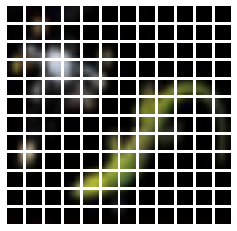

In [ ]:

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize = (4,4))
for i, patch in enumerate(patches[0]):
  ax = plt.subplot(n, n, i +1)
  patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
  plt.imshow(patch_img.numpy().astype('uint8'))
  plt.axis('off')

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [ ]:
position = tf.range(start=0, limit=144, delta=1)
position

<tf.Tensor: shape=(144,), dtype=int32, numpy=
array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143], dtype=int32)>

In [ ]:
patches[0]

<tf.Tensor: shape=(144, 108), dtype=float32, numpy=
array([[8.0000000e+00, 6.0000000e+00, 4.0000000e+00, ..., 5.9351850e+00,
        4.3209895e-01, 5.0987654e+00],
       [8.4444447e+00, 3.3888888e+00, 7.6111112e+00, ..., 6.9197525e+01,
        5.1595676e+01, 3.6672836e+01],
       [3.0000000e+00, 3.0555558e+00, 1.1111112e+01, ..., 6.7438264e+00,
        1.2037036e+01, 1.2277778e+01],
       ...,
       [0.0000000e+00, 5.5555344e-02, 0.0000000e+00, ..., 6.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 5.5555344e-02, 0.0000000e+00, ..., 6.0000000e+00,
        1.0000000e+00, 1.0000000e+00],
       [0.0000000e+00, 5.5555344e-02, 0.0000000e+00, ..., 7.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)>

In [ ]:
pos_emb = layers.Embedding(
            input_dim=144, output_dim=64
        )

In [ ]:
pos_emb(position)

<tf.Tensor: shape=(144, 64), dtype=float32, numpy=
array([[-0.017393  ,  0.03476483,  0.02592803, ...,  0.04680059,
        -0.01337119, -0.02129182],
       [-0.00931755,  0.00055482,  0.0470703 , ...,  0.0098343 ,
        -0.00884547, -0.04280616],
       [-0.00300659, -0.04514926,  0.00725985, ...,  0.02585385,
         0.03183283, -0.01896323],
       ...,
       [-0.00330585,  0.03509942, -0.03261719, ...,  0.00229333,
        -0.03517915, -0.03337842],
       [-0.01658456,  0.04694679, -0.0420274 , ..., -0.00399871,
        -0.02223175,  0.00459464],
       [ 0.01082369, -0.02599728, -0.00699525, ...,  0.00918229,
        -0.01427529, -0.0442184 ]], dtype=float32)>

In [ ]:
projection = layers.Dense(units=64)
projection(patches[0])

<tf.Tensor: shape=(144, 64), dtype=float32, numpy=
array([[  0.6264125 , -10.158005  ,   7.2577057 , ...,   6.314879  ,
          7.532458  ,   0.25044847],
       [ -2.219657  ,  -2.3542538 ,   8.53534   , ...,  43.411613  ,
         -5.24839   , -18.365847  ],
       [-13.265923  , -10.329147  ,  20.373756  , ...,   7.0325246 ,
          3.2497778 , -23.34047   ],
       ...,
       [ -3.7852037 ,   0.22870666,   1.2657931 , ...,   2.6196442 ,
         -1.0158832 ,  -2.3418052 ],
       [ -3.7852037 ,   0.22870666,   1.2657931 , ...,   2.6196442 ,
         -1.0158832 ,  -2.3418052 ],
       [ -3.6609495 ,   0.35115707,   1.1328446 , ...,   2.4123354 ,
         -1.1643898 ,  -2.8673167 ]], dtype=float32)>

In [ ]:
def create_vit_classifier():
  inputs = layers.Input(shape = input_shape)
  # Augment data.
  augmented = data_augmentation(inputs)
  # Create patches.
  patches = Patches(patch_size)(augmented)
  # Encode patches.
  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  #create multiple layers of the transformer block 
  for _ in range(transformer_layers):
    # layer normalization 1 
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # create a multi head attention layer 
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1, x1)
    # skip connection 1 
    x2 = layers.Add()([attention_output, encoded_patches])
    # layer normalization 2 
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    #MLP
    x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
    # skip connection 2 
    encoded_patches = layers.Add()([x3, x2])

  # create a [batch_size, projection_dim] tensor.
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  representation = layers.Dropout(0.5)(representation)
  # Add MLP.
  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
  # Classify outputs.
  logits = layers.Dense(num_classes)(features)
  # Create the Keras model.
  model = keras.Model(inputs=inputs, outputs=logits)
  return model


In [ ]:
vit_classifier = create_vit_classifier()

In [ ]:
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 72, 72, 3)    7           input_2[0][0]                    
__________________________________________________________________________________________________
patches_2 (Patches)             (None, None, 108)    0           data_augmentation[1][0]          
__________________________________________________________________________________________________
patch_encoder_1 (PatchEncoder)  (None, 144, 64)      16192       patches_2[0][0]                  
______________________________________________________________________________________________

In [ ]:
def run_experiment(model):
  optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

  model.compile(optimizer=optimizer, loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics = [
                           keras.metrics.SparseCategoricalAccuracy(name = 'accurcay'),
                           keras.metrics.SparseTopKCategoricalAccuracy(5, name = 'top-5-accuracy')
                ])
  checkpoint_filepath = '/tmp/checkpoint'
  checkpoint_callback = keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_accuracy', save_best_only=True, save_weights_only=True)

  history = model.fit(x = x_train, y=y_train, batch_size = batch_size, epochs = num_epochs, validation_split= 0.1, callbacks=[checkpoint_callback])

  model.load_weights(checkpoint_filepath)
  _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
  print(f'test acc:{round(accuracy * 100, 2)}%')
  print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

  return history 




In [ ]:
history = run_experiment(vit_classifier)

Epoch 1/100
176/176 [==============================] - 76s 381ms/step - loss: 4.9005 - accurcay: 0.0300 - top-5-accuracy: 0.1099 - val_loss: 3.9541 - val_accurcay: 0.1030 - val_top-5-accuracy: 0.3174
Epoch 2/100
176/176 [==============================] - 66s 373ms/step - loss: 4.0327 - accurcay: 0.0829 - top-5-accuracy: 0.2622 - val_loss: 3.5710 - val_accurcay: 0.1552 - val_top-5-accuracy: 0.4070
Epoch 3/100
176/176 [==============================] - 66s 373ms/step - loss: 3.7382 - accurcay: 0.1240 - top-5-accuracy: 0.3515 - val_loss: 3.3313 - val_accurcay: 0.2002 - val_top-5-accuracy: 0.4730
Epoch 4/100
176/176 [==============================] - 66s 374ms/step - loss: 3.5399 - accurcay: 0.1522 - top-5-accuracy: 0.4099 - val_loss: 3.1461 - val_accurcay: 0.2328 - val_top-5-accuracy: 0.5192
Epoch 5/100
176/176 [==============================] - 66s 373ms/step - loss: 3.3759 - accurcay: 0.1871 - top-5-accuracy: 0.4578 - val_loss: 3.0264 - val_accurcay: 0.2526 - val_top-5-accuracy: 0.5536


KeyboardInterrupt: ignored